In [2]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

%matplotlib inline

In [3]:
# Function for loading dataset from 'pickle' file
def load_data(file):
    # Open 'pickle' file
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """
        # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        input_data = d['features']
        # 1D numpy.ndarray type, for train = (34799,)
        target = d['labels']
        # 2D numpy.ndarray type, for train = (34799, 2)
        sizes = d['sizes']
        # 2D numpy.ndarray type, for train = (34799, 4)
        coords = d['coords']

    return input_data, target, sizes, coords

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
model_dir = "models/traffic_signs"
os.makedirs(model_dir, exist_ok=True)

train_path = "/content/drive/MyDrive/traffic_sign_data/train.pickle"
test_path = "/content/drive/MyDrive/traffic_sign_data/test.pickle"
valid_path = "/content/drive/MyDrive/traffic_sign_data/valid.pickle"
label_names_path = "/content/drive/MyDrive/traffic_sign_data/label_names.csv"
model_path = lambda name: f"{model_dir}/{name}.model"

In [15]:
X_train, y_train, *_ = load_data(train_path)
X_test, y_test, *_ = load_data(test_path)
X_valid, y_valid, *_ = load_data(valid_path)

In [16]:
label_names = pd.read_csv(label_names_path)

In [17]:
print("Training examples : ", len(X_train))
print("Validation examples : ", len(X_valid))
print("Testing examples : ", len(X_test))
print("Image data shape : ", X_train.shape)
print("Total classes : ", len(set(y_test)))

Training examples :  34799
Validation examples :  4410
Testing examples :  12630
Image data shape :  (34799, 32, 32, 3)
Total classes :  43


In [18]:
def draw_images_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array))
        image = image_array[index].squeeze()
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(image)

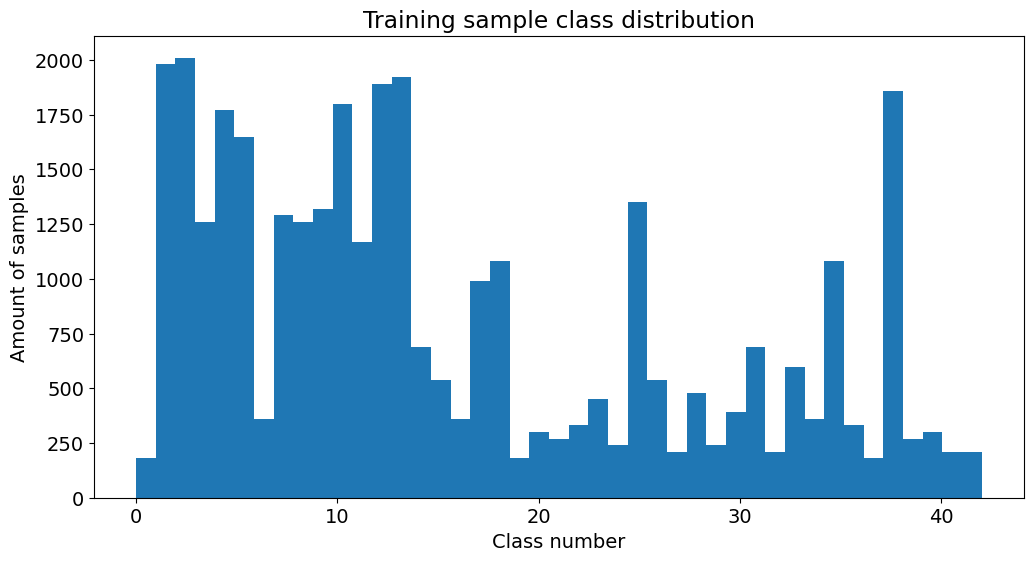

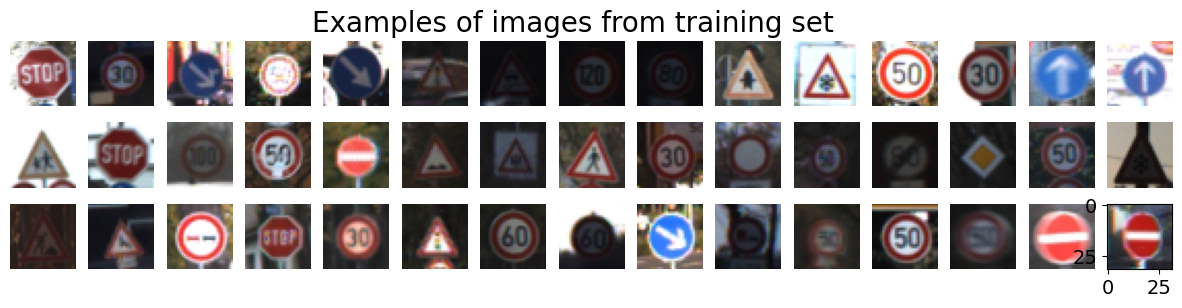

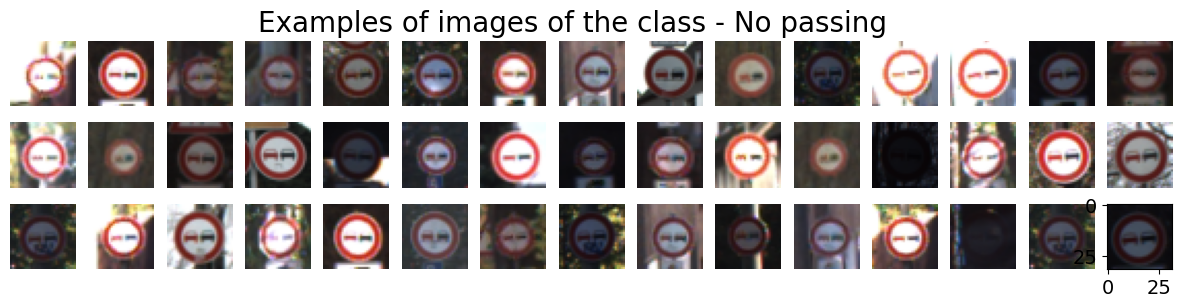

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
n, bins, patches = plt.hist(y_train, len(set(y_train)))
plt.xlabel('Class number')
plt.ylabel('Amount of samples')
plt.title('Training sample class distribution')

draw_images_examples(X_train, 15, 3, 'Examples of images from training set')

example_class = y_train[random.randint(0, len(y_train))]

X_train_one_label = X_train[np.where(y_train==example_class)]
draw_images_examples(X_train_one_label, 15, 3, f'Examples of images of the class - {label_names["SignName"][example_class]}')

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [22]:
batch_size = 64
learning_rate = 0.001
epochs = 30
weight_decay = 0.0001  # L2 Regularization
dropout_rate = 0.5

In [23]:
class TrafficSignDataset(Dataset):
    def __init__(self, path, transform=None):
        self.X, self.y, *_ = load_data(path)
        self.count = len(self.y)
        self.transform = transform

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform is not None:
            X = self.transform(X)
        return X, self.y[index]

    def __len__(self):
        return self.count

In [24]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [26]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

In [27]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [28]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [29]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [35]:
def train(model, criterion, optimizer, n_epochs, train_transforms, val_transforms, saving_model_path=None, custom_train_path=None):
    if custom_train_path is not None:
        train_dataset = TrafficSignDataset(custom_train_path, transform=train_transforms)
    else:
        train_dataset = TrafficSignDataset(train_path, transform=train_transforms)
    valid_dataset = TrafficSignDataset(valid_path, transform=val_transforms)
    test_dataset = TrafficSignDataset(test_path, transform=val_transforms)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)

In [31]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam is sooooo goood!
n_epochs = 20

## Preprocessing

In [34]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
])

val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
])

## Training

In [ ]:
train(model, criterion, optimizer, n_epochs, train_transforms, val_transforms, saving_model_path='base_model')


Fitting nn model


  5%|▌         | 1/20 [00:16<05:22, 16.95s/it]


epoch:   1, loss: 1.60834, valid loss: 0.82058, valid accruacy: 76.712%
Validation loss decreased (inf --> 0.820580). Saving model...


 10%|█         | 2/20 [00:34<05:08, 17.15s/it]


epoch:   2, loss: 0.40463, valid loss: 0.58470, valid accruacy: 84.308%
Validation loss decreased (0.820580 --> 0.584697). Saving model...


 15%|█▌        | 3/20 [00:50<04:44, 16.72s/it]


epoch:   3, loss: 0.23525, valid loss: 0.58168, valid accruacy: 86.599%
Validation loss decreased (0.584697 --> 0.581675). Saving model...


 20%|██        | 4/20 [01:05<04:18, 16.17s/it]


epoch:   4, loss: 0.16287, valid loss: 0.47749, valid accruacy: 87.574%
Validation loss decreased (0.581675 --> 0.477492). Saving model...


 25%|██▌       | 5/20 [01:20<03:56, 15.74s/it]


epoch:   5, loss: 0.12172, valid loss: 0.47775, valid accruacy: 88.209%


 30%|███       | 6/20 [01:36<03:41, 15.83s/it]


epoch:   6, loss: 0.09687, valid loss: 0.38206, valid accruacy: 90.091%
Validation loss decreased (0.477492 --> 0.382061). Saving model...


 35%|███▌      | 7/20 [01:51<03:21, 15.52s/it]


epoch:   7, loss: 0.08396, valid loss: 0.34039, valid accruacy: 91.497%
Validation loss decreased (0.382061 --> 0.340387). Saving model...


 40%|████      | 8/20 [02:06<03:05, 15.45s/it]


epoch:   8, loss: 0.07352, valid loss: 0.48426, valid accruacy: 89.161%


 45%|████▌     | 9/20 [02:22<02:50, 15.47s/it]


epoch:   9, loss: 0.06575, valid loss: 0.39143, valid accruacy: 91.406%


 50%|█████     | 10/20 [02:37<02:33, 15.36s/it]


epoch:  10, loss: 0.05491, valid loss: 0.45741, valid accruacy: 90.590%


 55%|█████▌    | 11/20 [02:52<02:17, 15.23s/it]


epoch:  11, loss: 0.05149, valid loss: 0.34275, valid accruacy: 92.472%


 60%|██████    | 12/20 [03:07<02:01, 15.16s/it]


epoch:  12, loss: 0.04676, valid loss: 0.34509, valid accruacy: 92.132%


 65%|██████▌   | 13/20 [03:22<01:45, 15.11s/it]


epoch:  13, loss: 0.04444, valid loss: 0.38769, valid accruacy: 92.200%


 70%|███████   | 14/20 [03:37<01:30, 15.12s/it]


epoch:  14, loss: 0.03954, valid loss: 0.35573, valid accruacy: 92.063%


 75%|███████▌  | 15/20 [03:54<01:17, 15.52s/it]


epoch:  15, loss: 0.04146, valid loss: 0.46439, valid accruacy: 91.587%


 80%|████████  | 16/20 [04:09<01:02, 15.55s/it]


epoch:  16, loss: 0.03264, valid loss: 0.51559, valid accruacy: 91.315%


 85%|████████▌ | 17/20 [04:25<00:46, 15.60s/it]


epoch:  17, loss: 0.03218, valid loss: 0.29107, valid accruacy: 93.356%
Validation loss decreased (0.340387 --> 0.291066). Saving model...


 90%|█████████ | 18/20 [04:40<00:30, 15.41s/it]


epoch:  18, loss: 0.03394, valid loss: 0.50042, valid accruacy: 91.497%


 95%|█████████▌| 19/20 [04:55<00:15, 15.27s/it]


epoch:  19, loss: 0.03103, valid loss: 0.48804, valid accruacy: 91.202%


100%|██████████| 20/20 [05:10<00:00, 15.52s/it]


epoch:  20, loss: 0.03385, valid loss: 0.47327, valid accruacy: 92.063%
Fit time: 310.41 s


Validation Accuracy: 93.40%
Saving model


93.40136054421768

In [41]:
class NewModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 43)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))

        x = x.view(-1, 256 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)

        return x


* Експериментувала з кількістю шарів та кількістю фільтрів для шарів, збільшила їх у порівнянні з базовою моделлю. Найкраще себе показала саме ця модель на досить велику кількість шарів (3 згорткові шари на 64, 128, 256 та 4 лінійні шари). Більша глибина дозволяє краще видобувати корисні характеристики.

* Експериментувала з функціями активації, а саме обирала між tanh та relu. Краще для градієнтів показала себе relu.

* Нормалізувала дані після кожного згорткового шару для стабільності навчання.

* Також застосувала MaxPooling після кожного згорткового шару для виділення важливих особливостей.

* Додала Dropout (пробувала різну ймовірність, 0.2 0.3 0.4 0.5, найкраще показала себе 0.3) для уникнення перенавчання.

In [42]:
model = NewModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

In [ ]:
train(model, criterion, optimizer, n_epochs, train_transforms, val_transforms, saving_model_path='new_model')


Fitting nn model


  5%|▌         | 1/20 [00:16<05:15, 16.60s/it]


epoch:   1, loss: 2.14194, valid loss: 1.06668, valid accruacy: 61.111%
Validation loss decreased (inf --> 1.066685). Saving model...


 10%|█         | 2/20 [00:33<05:01, 16.77s/it]


epoch:   2, loss: 0.87273, valid loss: 0.51040, valid accruacy: 84.739%
Validation loss decreased (1.066685 --> 0.510401). Saving model...


 15%|█▌        | 3/20 [00:49<04:42, 16.63s/it]


epoch:   3, loss: 0.54626, valid loss: 0.32334, valid accruacy: 90.930%
Validation loss decreased (0.510401 --> 0.323340). Saving model...


 20%|██        | 4/20 [01:06<04:23, 16.49s/it]


epoch:   4, loss: 0.40244, valid loss: 0.22362, valid accruacy: 93.764%
Validation loss decreased (0.323340 --> 0.223619). Saving model...


 25%|██▌       | 5/20 [01:22<04:06, 16.42s/it]


epoch:   5, loss: 0.32509, valid loss: 0.21753, valid accruacy: 94.535%
Validation loss decreased (0.223619 --> 0.217534). Saving model...


 30%|███       | 6/20 [01:39<03:53, 16.68s/it]


epoch:   6, loss: 0.28192, valid loss: 0.22297, valid accruacy: 93.560%


 35%|███▌      | 7/20 [01:56<03:38, 16.85s/it]


epoch:   7, loss: 0.24899, valid loss: 0.20652, valid accruacy: 93.651%
Validation loss decreased (0.217534 --> 0.206521). Saving model...


 40%|████      | 8/20 [02:13<03:19, 16.67s/it]


epoch:   8, loss: 0.22926, valid loss: 0.19395, valid accruacy: 95.079%
Validation loss decreased (0.206521 --> 0.193949). Saving model...


 45%|████▌     | 9/20 [02:29<03:02, 16.61s/it]


epoch:   9, loss: 0.21335, valid loss: 0.17665, valid accruacy: 95.556%
Validation loss decreased (0.193949 --> 0.176651). Saving model...


 50%|█████     | 10/20 [02:46<02:47, 16.76s/it]


epoch:  10, loss: 0.19290, valid loss: 0.15291, valid accruacy: 95.828%
Validation loss decreased (0.176651 --> 0.152906). Saving model...


 55%|█████▌    | 11/20 [03:03<02:29, 16.64s/it]


epoch:  11, loss: 0.18470, valid loss: 0.14909, valid accruacy: 96.032%
Validation loss decreased (0.152906 --> 0.149091). Saving model...


 60%|██████    | 12/20 [03:19<02:12, 16.53s/it]


epoch:  12, loss: 0.16726, valid loss: 0.21794, valid accruacy: 94.490%


 65%|██████▌   | 13/20 [03:35<01:55, 16.48s/it]


epoch:  13, loss: 0.15655, valid loss: 0.13054, valid accruacy: 97.143%
Validation loss decreased (0.149091 --> 0.130540). Saving model...


 70%|███████   | 14/20 [03:52<01:40, 16.67s/it]


epoch:  14, loss: 0.15759, valid loss: 0.15127, valid accruacy: 96.054%


 75%|███████▌  | 15/20 [04:09<01:22, 16.57s/it]


epoch:  15, loss: 0.14642, valid loss: 0.15996, valid accruacy: 96.168%


 80%|████████  | 16/20 [04:25<01:05, 16.46s/it]


epoch:  16, loss: 0.13756, valid loss: 0.16278, valid accruacy: 95.669%


 85%|████████▌ | 17/20 [04:41<00:49, 16.36s/it]


epoch:  17, loss: 0.13425, valid loss: 0.15560, valid accruacy: 97.052%


 90%|█████████ | 18/20 [04:59<00:33, 16.71s/it]


epoch:  18, loss: 0.12523, valid loss: 0.14837, valid accruacy: 96.893%


 95%|█████████▌| 19/20 [05:16<00:16, 16.89s/it]


epoch:  19, loss: 0.12829, valid loss: 0.14194, valid accruacy: 96.009%


100%|██████████| 20/20 [05:32<00:00, 16.63s/it]


epoch:  20, loss: 0.11625, valid loss: 0.16123, valid accruacy: 96.054%
Fit time: 332.59 s


Validation Accuracy: 97.21%
Saving model


97.2108843537415

In [ ]:
from itertools import product

learning_rates = [0.01, 0.001]
batch_sizes = [32, 64, 128]
n_epochs_list = [20, 10, 15]
optimizers = ['Adam', 'SGD']

def get_optimizer(model, optimizer_name, lr):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

best_accuracy = 0.0
best_params = None

hyperparameter_combinations = list(product(learning_rates, batch_sizes, n_epochs_list, optimizers))

for lr, batch_size, n_epochs, optimizer_name in hyperparameter_combinations:
    print(f"\nTraining with: lr={lr}, batch_size={batch_size}, epochs={n_epochs}, optimizer={optimizer_name}")

    model = NewModel().to(device)
    optimizer = get_optimizer(model, optimizer_name, lr)
    criterion = nn.CrossEntropyLoss()

    valid_accuracy = train(
        model,
        criterion,
        optimizer,
        n_epochs,
        transforms,
        batch_size=batch_size,
        saving_model_path=None
    )

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_params = (lr, batch_size, n_epochs, optimizer_name)

print(f"\nBest Hyperparameters:")
print(f"Learning Rate: {best_params[0]}")
print(f"Batch Size: {best_params[1]}")
print(f"Epochs: {best_params[2]}")
print(f"Optimizer: {best_params[3]}")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")



Training with: lr=0.01, batch_size=32, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:18<05:56, 18.78s/it]


epoch:   1, loss: 3.42928, valid loss: 3.12350, valid accruacy: 13.696%
Validation loss decreased (inf --> 3.123501). Saving model...


 10%|█         | 2/20 [00:36<05:28, 18.25s/it]


epoch:   2, loss: 2.65102, valid loss: 2.37475, valid accruacy: 26.236%
Validation loss decreased (3.123501 --> 2.374748). Saving model...


 15%|█▌        | 3/20 [00:54<05:07, 18.10s/it]


epoch:   3, loss: 2.28002, valid loss: 2.12101, valid accruacy: 27.868%
Validation loss decreased (2.374748 --> 2.121014). Saving model...


 20%|██        | 4/20 [01:13<04:53, 18.36s/it]


epoch:   4, loss: 2.11673, valid loss: 1.93217, valid accruacy: 33.968%
Validation loss decreased (2.121014 --> 1.932171). Saving model...


 25%|██▌       | 5/20 [01:31<04:31, 18.12s/it]


epoch:   5, loss: 2.01543, valid loss: 1.91012, valid accruacy: 33.016%
Validation loss decreased (1.932171 --> 1.910125). Saving model...


 30%|███       | 6/20 [01:48<04:12, 18.02s/it]


epoch:   6, loss: 1.97466, valid loss: 1.85056, valid accruacy: 34.762%
Validation loss decreased (1.910125 --> 1.850562). Saving model...


 35%|███▌      | 7/20 [02:07<03:56, 18.18s/it]


epoch:   7, loss: 1.92557, valid loss: 1.87064, valid accruacy: 36.667%


 40%|████      | 8/20 [02:25<03:39, 18.27s/it]


epoch:   8, loss: 1.89434, valid loss: 1.76263, valid accruacy: 37.755%
Validation loss decreased (1.850562 --> 1.762627). Saving model...


 45%|████▌     | 9/20 [02:45<03:26, 18.79s/it]


epoch:   9, loss: 1.84706, valid loss: 1.67507, valid accruacy: 42.154%
Validation loss decreased (1.762627 --> 1.675065). Saving model...


 50%|█████     | 10/20 [03:03<03:05, 18.54s/it]


epoch:  10, loss: 1.79346, valid loss: 1.68444, valid accruacy: 40.227%


 55%|█████▌    | 11/20 [03:21<02:45, 18.39s/it]


epoch:  11, loss: 1.76998, valid loss: 1.80555, valid accruacy: 36.463%


 60%|██████    | 12/20 [03:40<02:28, 18.53s/it]


epoch:  12, loss: 1.76327, valid loss: 1.72102, valid accruacy: 42.834%


 65%|██████▌   | 13/20 [03:58<02:08, 18.39s/it]


epoch:  13, loss: 1.74393, valid loss: 1.59531, valid accruacy: 44.376%
Validation loss decreased (1.675065 --> 1.595309). Saving model...


 70%|███████   | 14/20 [04:17<01:50, 18.38s/it]


epoch:  14, loss: 1.74963, valid loss: 1.60664, valid accruacy: 43.243%


 75%|███████▌  | 15/20 [04:35<01:31, 18.35s/it]


epoch:  15, loss: 1.70370, valid loss: 1.61947, valid accruacy: 40.952%


 80%|████████  | 16/20 [04:53<01:12, 18.18s/it]


epoch:  16, loss: 1.71810, valid loss: 1.60566, valid accruacy: 43.197%


 85%|████████▌ | 17/20 [05:12<00:55, 18.48s/it]


epoch:  17, loss: 1.66619, valid loss: 1.66629, valid accruacy: 43.356%


 90%|█████████ | 18/20 [05:30<00:36, 18.34s/it]


epoch:  18, loss: 1.66817, valid loss: 1.75538, valid accruacy: 37.075%


 95%|█████████▌| 19/20 [05:48<00:18, 18.32s/it]


epoch:  19, loss: 1.65149, valid loss: 1.78660, valid accruacy: 42.313%


100%|██████████| 20/20 [06:08<00:00, 18.41s/it]


epoch:  20, loss: 1.69690, valid loss: 1.68836, valid accruacy: 40.862%
Fit time: 368.26 s


Validation Accuracy: 43.63%

Training with: lr=0.01, batch_size=32, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:17<05:35, 17.64s/it]


epoch:   1, loss: 2.22239, valid loss: 1.36900, valid accruacy: 51.519%
Validation loss decreased (inf --> 1.368999). Saving model...


 10%|█         | 2/20 [00:35<05:21, 17.89s/it]


epoch:   2, loss: 1.33931, valid loss: 0.78725, valid accruacy: 74.014%
Validation loss decreased (1.368999 --> 0.787249). Saving model...


 15%|█▌        | 3/20 [00:53<05:03, 17.84s/it]


epoch:   3, loss: 0.92464, valid loss: 0.45371, valid accruacy: 85.147%
Validation loss decreased (0.787249 --> 0.453709). Saving model...


 20%|██        | 4/20 [01:11<04:43, 17.73s/it]


epoch:   4, loss: 0.59080, valid loss: 0.29846, valid accruacy: 91.406%
Validation loss decreased (0.453709 --> 0.298461). Saving model...


 25%|██▌       | 5/20 [01:29<04:29, 17.96s/it]


epoch:   5, loss: 0.40569, valid loss: 0.17052, valid accruacy: 95.397%
Validation loss decreased (0.298461 --> 0.170523). Saving model...


 30%|███       | 6/20 [01:47<04:09, 17.85s/it]


epoch:   6, loss: 0.27545, valid loss: 0.16075, valid accruacy: 95.896%
Validation loss decreased (0.170523 --> 0.160752). Saving model...


 35%|███▌      | 7/20 [02:04<03:50, 17.76s/it]


epoch:   7, loss: 0.21078, valid loss: 0.13970, valid accruacy: 96.100%
Validation loss decreased (0.160752 --> 0.139697). Saving model...


 40%|████      | 8/20 [02:23<03:35, 17.98s/it]


epoch:   8, loss: 0.16084, valid loss: 0.14879, valid accruacy: 95.918%


 45%|████▌     | 9/20 [02:40<03:16, 17.90s/it]


epoch:   9, loss: 0.12948, valid loss: 0.13640, valid accruacy: 95.986%
Validation loss decreased (0.139697 --> 0.136401). Saving model...


 50%|█████     | 10/20 [02:59<03:02, 18.20s/it]


epoch:  10, loss: 0.10999, valid loss: 0.13121, valid accruacy: 96.576%
Validation loss decreased (0.136401 --> 0.131206). Saving model...


 55%|█████▌    | 11/20 [03:18<02:44, 18.29s/it]


epoch:  11, loss: 0.08301, valid loss: 0.08526, valid accruacy: 97.664%
Validation loss decreased (0.131206 --> 0.085260). Saving model...


 60%|██████    | 12/20 [03:35<02:24, 18.06s/it]


epoch:  12, loss: 0.07678, valid loss: 0.10605, valid accruacy: 96.757%


 65%|██████▌   | 13/20 [03:53<02:05, 17.95s/it]


epoch:  13, loss: 0.07076, valid loss: 0.11904, valid accruacy: 96.848%


 70%|███████   | 14/20 [04:12<01:49, 18.20s/it]


epoch:  14, loss: 0.05945, valid loss: 0.08814, valid accruacy: 97.506%


 75%|███████▌  | 15/20 [04:29<01:30, 18.05s/it]


epoch:  15, loss: 0.05412, valid loss: 0.12103, valid accruacy: 96.780%


 80%|████████  | 16/20 [04:47<01:11, 17.89s/it]


epoch:  16, loss: 0.05151, valid loss: 0.08303, valid accruacy: 97.642%
Validation loss decreased (0.085260 --> 0.083031). Saving model...


 85%|████████▌ | 17/20 [05:05<00:54, 18.06s/it]


epoch:  17, loss: 0.04793, valid loss: 0.07637, valid accruacy: 97.868%
Validation loss decreased (0.083031 --> 0.076374). Saving model...


 90%|█████████ | 18/20 [05:23<00:35, 17.96s/it]


epoch:  18, loss: 0.04278, valid loss: 0.08856, valid accruacy: 97.460%


 95%|█████████▌| 19/20 [05:41<00:17, 17.97s/it]


epoch:  19, loss: 0.04143, valid loss: 0.07058, valid accruacy: 98.005%
Validation loss decreased (0.076374 --> 0.070581). Saving model...


100%|██████████| 20/20 [06:01<00:00, 18.05s/it]


epoch:  20, loss: 0.03892, valid loss: 0.09672, valid accruacy: 97.596%
Fit time: 361.09 s


Validation Accuracy: 98.05%

Training with: lr=0.01, batch_size=64, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:16<05:10, 16.32s/it]


epoch:   1, loss: 3.53238, valid loss: 3.55459, valid accruacy: 5.442%
Validation loss decreased (inf --> 3.554586). Saving model...


 10%|█         | 2/20 [00:32<04:53, 16.30s/it]


epoch:   2, loss: 3.48458, valid loss: 3.54921, valid accruacy: 5.283%
Validation loss decreased (3.554586 --> 3.549208). Saving model...


 15%|█▌        | 3/20 [00:50<04:45, 16.82s/it]


epoch:   3, loss: 3.47430, valid loss: 3.53846, valid accruacy: 7.143%
Validation loss decreased (3.549208 --> 3.538461). Saving model...


 20%|██        | 4/20 [01:06<04:25, 16.59s/it]


epoch:   4, loss: 3.47233, valid loss: 3.53494, valid accruacy: 7.052%
Validation loss decreased (3.538461 --> 3.534936). Saving model...


 25%|██▌       | 5/20 [01:22<04:06, 16.42s/it]


epoch:   5, loss: 3.47212, valid loss: 3.53217, valid accruacy: 6.304%
Validation loss decreased (3.534936 --> 3.532171). Saving model...


 30%|███       | 6/20 [01:38<03:48, 16.35s/it]


epoch:   6, loss: 3.47261, valid loss: 3.53358, valid accruacy: 6.259%


 35%|███▌      | 7/20 [01:55<03:35, 16.59s/it]


epoch:   7, loss: 3.48089, valid loss: 3.55481, valid accruacy: 5.442%


 40%|████      | 8/20 [02:12<03:19, 16.60s/it]


epoch:   8, loss: 3.47920, valid loss: 3.55759, valid accruacy: 5.442%


 45%|████▌     | 9/20 [02:28<03:01, 16.51s/it]


epoch:   9, loss: 3.47930, valid loss: 3.55556, valid accruacy: 5.442%


 50%|█████     | 10/20 [02:44<02:44, 16.46s/it]


epoch:  10, loss: 3.47890, valid loss: 3.55567, valid accruacy: 5.442%


 55%|█████▌    | 11/20 [03:02<02:30, 16.71s/it]


epoch:  11, loss: 3.47917, valid loss: 3.55510, valid accruacy: 5.442%


 60%|██████    | 12/20 [03:19<02:16, 17.01s/it]


epoch:  12, loss: 3.47907, valid loss: 3.55553, valid accruacy: 5.442%


 65%|██████▌   | 13/20 [03:36<01:57, 16.78s/it]


epoch:  13, loss: 3.47919, valid loss: 3.55651, valid accruacy: 5.442%


 70%|███████   | 14/20 [03:52<01:39, 16.65s/it]


epoch:  14, loss: 3.47917, valid loss: 3.55649, valid accruacy: 5.442%


 70%|███████   | 14/20 [04:08<01:46, 17.78s/it]


epoch:  15, loss: 3.47896, valid loss: 3.55581, valid accruacy: 5.442%
Terminated Training for Early Stopping at Epoch 15
Fit time: 248.87 s


Validation Accuracy: 6.28%

Training with: lr=0.01, batch_size=64, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:16<05:05, 16.06s/it]


epoch:   1, loss: 2.08503, valid loss: 1.25972, valid accruacy: 59.728%
Validation loss decreased (inf --> 1.259719). Saving model...


 10%|█         | 2/20 [00:32<04:50, 16.16s/it]


epoch:   2, loss: 0.85944, valid loss: 0.51028, valid accruacy: 82.857%
Validation loss decreased (1.259719 --> 0.510279). Saving model...


 15%|█▌        | 3/20 [00:48<04:34, 16.14s/it]


epoch:   3, loss: 0.47686, valid loss: 0.29434, valid accruacy: 90.181%
Validation loss decreased (0.510279 --> 0.294343). Saving model...


 20%|██        | 4/20 [01:04<04:19, 16.24s/it]


epoch:   4, loss: 0.31201, valid loss: 0.20403, valid accruacy: 94.694%
Validation loss decreased (0.294343 --> 0.204027). Saving model...


 25%|██▌       | 5/20 [01:21<04:05, 16.36s/it]


epoch:   5, loss: 0.24228, valid loss: 0.18794, valid accruacy: 94.172%
Validation loss decreased (0.204027 --> 0.187944). Saving model...


 30%|███       | 6/20 [01:37<03:47, 16.26s/it]


epoch:   6, loss: 0.19040, valid loss: 0.18207, valid accruacy: 94.898%
Validation loss decreased (0.187944 --> 0.182070). Saving model...


 35%|███▌      | 7/20 [01:53<03:30, 16.23s/it]


epoch:   7, loss: 0.14660, valid loss: 0.11140, valid accruacy: 96.599%
Validation loss decreased (0.182070 --> 0.111400). Saving model...


 40%|████      | 8/20 [02:10<03:18, 16.52s/it]


epoch:   8, loss: 0.12746, valid loss: 0.12465, valid accruacy: 96.440%


 45%|████▌     | 9/20 [02:27<03:02, 16.58s/it]


epoch:   9, loss: 0.10936, valid loss: 0.12065, valid accruacy: 96.757%


 50%|█████     | 10/20 [02:43<02:43, 16.38s/it]


epoch:  10, loss: 0.09307, valid loss: 0.11979, valid accruacy: 96.531%


 55%|█████▌    | 11/20 [02:59<02:27, 16.38s/it]


epoch:  11, loss: 0.08270, valid loss: 0.13160, valid accruacy: 96.599%


 60%|██████    | 12/20 [03:15<02:10, 16.28s/it]


epoch:  12, loss: 0.07749, valid loss: 0.09373, valid accruacy: 97.211%
Validation loss decreased (0.111400 --> 0.093728). Saving model...


 65%|██████▌   | 13/20 [03:32<01:54, 16.43s/it]


epoch:  13, loss: 0.07454, valid loss: 0.09639, valid accruacy: 97.075%


 70%|███████   | 14/20 [03:48<01:38, 16.35s/it]


epoch:  14, loss: 0.06162, valid loss: 0.11424, valid accruacy: 97.256%


 75%|███████▌  | 15/20 [04:04<01:21, 16.26s/it]


epoch:  15, loss: 0.06278, valid loss: 0.08718, valid accruacy: 97.914%
Validation loss decreased (0.093728 --> 0.087182). Saving model...


 80%|████████  | 16/20 [04:20<01:04, 16.19s/it]


epoch:  16, loss: 0.05329, valid loss: 0.07382, valid accruacy: 97.823%
Validation loss decreased (0.087182 --> 0.073817). Saving model...


 85%|████████▌ | 17/20 [04:37<00:48, 16.22s/it]


epoch:  17, loss: 0.04990, valid loss: 0.08430, valid accruacy: 97.937%


 90%|█████████ | 18/20 [04:53<00:32, 16.36s/it]


epoch:  18, loss: 0.04978, valid loss: 0.10336, valid accruacy: 97.642%


 95%|█████████▌| 19/20 [05:10<00:16, 16.55s/it]


epoch:  19, loss: 0.04697, valid loss: 0.10305, valid accruacy: 97.188%


100%|██████████| 20/20 [05:26<00:00, 16.34s/it]


epoch:  20, loss: 0.03768, valid loss: 0.08949, valid accruacy: 97.642%
Fit time: 326.80 s


Validation Accuracy: 97.82%

Training with: lr=0.01, batch_size=128, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:15<05:02, 15.93s/it]


epoch:   1, loss: 3.33375, valid loss: 2.81251, valid accruacy: 17.710%
Validation loss decreased (inf --> 2.812510). Saving model...


 10%|█         | 2/20 [00:32<04:48, 16.05s/it]


epoch:   2, loss: 2.82998, valid loss: 2.52553, valid accruacy: 27.528%
Validation loss decreased (2.812510 --> 2.525525). Saving model...


 15%|█▌        | 3/20 [00:47<04:28, 15.82s/it]


epoch:   3, loss: 2.51944, valid loss: 2.06429, valid accruacy: 31.293%
Validation loss decreased (2.525525 --> 2.064294). Saving model...


 20%|██        | 4/20 [01:03<04:12, 15.76s/it]


epoch:   4, loss: 2.29145, valid loss: 1.97964, valid accruacy: 35.873%
Validation loss decreased (2.064294 --> 1.979643). Saving model...


 25%|██▌       | 5/20 [01:19<03:56, 15.79s/it]


epoch:   5, loss: 2.02852, valid loss: 1.71569, valid accruacy: 42.766%
Validation loss decreased (1.979643 --> 1.715691). Saving model...


 30%|███       | 6/20 [01:34<03:41, 15.80s/it]


epoch:   6, loss: 1.81996, valid loss: 1.62812, valid accruacy: 41.655%
Validation loss decreased (1.715691 --> 1.628116). Saving model...


 35%|███▌      | 7/20 [01:51<03:27, 15.98s/it]


epoch:   7, loss: 1.68839, valid loss: 1.51323, valid accruacy: 45.034%
Validation loss decreased (1.628116 --> 1.513227). Saving model...


 40%|████      | 8/20 [02:06<03:10, 15.88s/it]


epoch:   8, loss: 1.54728, valid loss: 1.58240, valid accruacy: 42.834%


 45%|████▌     | 9/20 [02:22<02:53, 15.80s/it]


epoch:   9, loss: 1.39949, valid loss: 1.36178, valid accruacy: 53.197%
Validation loss decreased (1.513227 --> 1.361781). Saving model...


 50%|█████     | 10/20 [02:39<02:41, 16.12s/it]


epoch:  10, loss: 1.25830, valid loss: 1.38519, valid accruacy: 48.980%


 55%|█████▌    | 11/20 [02:55<02:23, 15.98s/it]


epoch:  11, loss: 1.15420, valid loss: 1.21218, valid accruacy: 56.644%
Validation loss decreased (1.361781 --> 1.212176). Saving model...


 60%|██████    | 12/20 [03:11<02:08, 16.03s/it]


epoch:  12, loss: 1.04993, valid loss: 1.11501, valid accruacy: 56.259%
Validation loss decreased (1.212176 --> 1.115013). Saving model...


 65%|██████▌   | 13/20 [03:27<01:52, 16.03s/it]


epoch:  13, loss: 0.98646, valid loss: 1.10724, valid accruacy: 62.381%
Validation loss decreased (1.115013 --> 1.107237). Saving model...


 70%|███████   | 14/20 [03:42<01:35, 15.91s/it]


epoch:  14, loss: 0.94800, valid loss: 1.15193, valid accruacy: 57.982%


 75%|███████▌  | 15/20 [03:58<01:19, 15.81s/it]


epoch:  15, loss: 0.92211, valid loss: 1.14455, valid accruacy: 57.823%


 80%|████████  | 16/20 [04:14<01:02, 15.74s/it]


epoch:  16, loss: 0.89958, valid loss: 1.14144, valid accruacy: 59.365%


 85%|████████▌ | 17/20 [04:29<00:47, 15.79s/it]


epoch:  17, loss: 0.85146, valid loss: 1.11323, valid accruacy: 61.995%


 90%|█████████ | 18/20 [04:46<00:31, 15.92s/it]


epoch:  18, loss: 0.81561, valid loss: 1.11136, valid accruacy: 60.204%


 95%|█████████▌| 19/20 [05:01<00:15, 15.81s/it]


epoch:  19, loss: 0.81499, valid loss: 1.00114, valid accruacy: 62.449%
Validation loss decreased (1.107237 --> 1.001145). Saving model...


100%|██████████| 20/20 [05:17<00:00, 15.86s/it]


epoch:  20, loss: 0.80587, valid loss: 1.23343, valid accruacy: 57.143%
Fit time: 317.14 s


Validation Accuracy: 62.31%

Training with: lr=0.01, batch_size=128, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:16<05:14, 16.55s/it]


epoch:   1, loss: 2.39845, valid loss: 1.50716, valid accruacy: 51.519%
Validation loss decreased (inf --> 1.507157). Saving model...


 10%|█         | 2/20 [00:32<04:55, 16.44s/it]


epoch:   2, loss: 1.03590, valid loss: 0.55205, valid accruacy: 84.059%
Validation loss decreased (1.507157 --> 0.552051). Saving model...


 15%|█▌        | 3/20 [00:48<04:32, 16.05s/it]


epoch:   3, loss: 0.46964, valid loss: 0.32203, valid accruacy: 91.746%
Validation loss decreased (0.552051 --> 0.322028). Saving model...


 20%|██        | 4/20 [01:04<04:14, 15.88s/it]


epoch:   4, loss: 0.30335, valid loss: 0.20680, valid accruacy: 93.696%
Validation loss decreased (0.322028 --> 0.206800). Saving model...


 25%|██▌       | 5/20 [01:19<03:55, 15.72s/it]


epoch:   5, loss: 0.21219, valid loss: 0.20923, valid accruacy: 94.014%


 30%|███       | 6/20 [01:34<03:38, 15.61s/it]


epoch:   6, loss: 0.16379, valid loss: 0.16009, valid accruacy: 94.943%
Validation loss decreased (0.206800 --> 0.160092). Saving model...


 35%|███▌      | 7/20 [01:50<03:23, 15.65s/it]


epoch:   7, loss: 0.13285, valid loss: 0.18523, valid accruacy: 94.785%


 40%|████      | 8/20 [02:06<03:09, 15.79s/it]


epoch:   8, loss: 0.11321, valid loss: 0.17581, valid accruacy: 96.440%


 45%|████▌     | 9/20 [02:22<02:52, 15.68s/it]


epoch:   9, loss: 0.10484, valid loss: 0.15724, valid accruacy: 96.372%
Validation loss decreased (0.160092 --> 0.157242). Saving model...


 50%|█████     | 10/20 [02:37<02:36, 15.63s/it]


epoch:  10, loss: 0.08454, valid loss: 0.16398, valid accruacy: 96.327%


 55%|█████▌    | 11/20 [02:53<02:19, 15.55s/it]


epoch:  11, loss: 0.06955, valid loss: 0.19524, valid accruacy: 95.873%


 60%|██████    | 12/20 [03:08<02:04, 15.51s/it]


epoch:  12, loss: 0.06535, valid loss: 0.15762, valid accruacy: 96.349%


 65%|██████▌   | 13/20 [03:25<01:51, 15.98s/it]


epoch:  13, loss: 0.05833, valid loss: 0.11258, valid accruacy: 97.075%
Validation loss decreased (0.157242 --> 0.112579). Saving model...


 70%|███████   | 14/20 [03:41<01:35, 16.00s/it]


epoch:  14, loss: 0.05512, valid loss: 0.14617, valid accruacy: 96.735%


 75%|███████▌  | 15/20 [03:56<01:18, 15.78s/it]


epoch:  15, loss: 0.05014, valid loss: 0.13734, valid accruacy: 96.395%


 80%|████████  | 16/20 [04:12<01:02, 15.67s/it]


epoch:  16, loss: 0.04911, valid loss: 0.12180, valid accruacy: 96.576%


 85%|████████▌ | 17/20 [04:27<00:46, 15.60s/it]


epoch:  17, loss: 0.03898, valid loss: 0.10914, valid accruacy: 97.324%
Validation loss decreased (0.112579 --> 0.109142). Saving model...


 90%|█████████ | 18/20 [04:43<00:31, 15.55s/it]


epoch:  18, loss: 0.04363, valid loss: 0.14301, valid accruacy: 96.961%


 95%|█████████▌| 19/20 [04:59<00:15, 15.65s/it]


epoch:  19, loss: 0.04196, valid loss: 0.13535, valid accruacy: 97.347%


100%|██████████| 20/20 [05:14<00:00, 15.75s/it]


epoch:  20, loss: 0.03367, valid loss: 0.10946, valid accruacy: 97.211%
Fit time: 314.97 s


Validation Accuracy: 97.30%

Training with: lr=0.001, batch_size=32, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:17<05:35, 17.65s/it]


epoch:   1, loss: 2.11492, valid loss: 1.29129, valid accruacy: 55.805%
Validation loss decreased (inf --> 1.291295). Saving model...


 10%|█         | 2/20 [00:36<05:25, 18.08s/it]


epoch:   2, loss: 1.06138, valid loss: 0.59716, valid accruacy: 80.249%
Validation loss decreased (1.291295 --> 0.597155). Saving model...


 15%|█▌        | 3/20 [00:54<05:13, 18.47s/it]


epoch:   3, loss: 0.72114, valid loss: 0.44373, valid accruacy: 84.490%
Validation loss decreased (0.597155 --> 0.443732). Saving model...


 20%|██        | 4/20 [01:12<04:51, 18.22s/it]


epoch:   4, loss: 0.57314, valid loss: 0.30995, valid accruacy: 90.930%
Validation loss decreased (0.443732 --> 0.309949). Saving model...


 25%|██▌       | 5/20 [01:31<04:35, 18.35s/it]


epoch:   5, loss: 0.49587, valid loss: 0.29551, valid accruacy: 91.678%
Validation loss decreased (0.309949 --> 0.295506). Saving model...


 30%|███       | 6/20 [01:49<04:14, 18.16s/it]


epoch:   6, loss: 0.43491, valid loss: 0.26647, valid accruacy: 94.218%
Validation loss decreased (0.295506 --> 0.266470). Saving model...


 35%|███▌      | 7/20 [02:07<03:55, 18.12s/it]


epoch:   7, loss: 0.36217, valid loss: 0.23977, valid accruacy: 93.401%
Validation loss decreased (0.266470 --> 0.239772). Saving model...


 40%|████      | 8/20 [02:25<03:38, 18.24s/it]


epoch:   8, loss: 0.31080, valid loss: 0.31949, valid accruacy: 92.154%


 45%|████▌     | 9/20 [02:43<03:18, 18.07s/it]


epoch:   9, loss: 0.27375, valid loss: 0.17884, valid accruacy: 95.828%
Validation loss decreased (0.239772 --> 0.178843). Saving model...


 50%|█████     | 10/20 [03:01<03:00, 18.07s/it]


epoch:  10, loss: 0.24780, valid loss: 0.17398, valid accruacy: 95.714%
Validation loss decreased (0.178843 --> 0.173978). Saving model...


 55%|█████▌    | 11/20 [03:19<02:42, 18.06s/it]


epoch:  11, loss: 0.22587, valid loss: 0.19417, valid accruacy: 94.943%


 60%|██████    | 12/20 [03:37<02:23, 17.98s/it]


epoch:  12, loss: 0.20132, valid loss: 0.15531, valid accruacy: 96.122%
Validation loss decreased (0.173978 --> 0.155312). Saving model...


 65%|██████▌   | 13/20 [03:56<02:08, 18.42s/it]


epoch:  13, loss: 0.17560, valid loss: 0.14159, valid accruacy: 96.395%
Validation loss decreased (0.155312 --> 0.141592). Saving model...


 70%|███████   | 14/20 [04:14<01:48, 18.16s/it]


epoch:  14, loss: 0.15780, valid loss: 0.14381, valid accruacy: 96.780%


 75%|███████▌  | 15/20 [04:31<01:29, 17.96s/it]


epoch:  15, loss: 0.13916, valid loss: 0.13726, valid accruacy: 96.621%
Validation loss decreased (0.141592 --> 0.137261). Saving model...


 80%|████████  | 16/20 [04:50<01:12, 18.12s/it]


epoch:  16, loss: 0.12506, valid loss: 0.11722, valid accruacy: 96.984%
Validation loss decreased (0.137261 --> 0.117222). Saving model...


 85%|████████▌ | 17/20 [05:07<00:53, 17.99s/it]


epoch:  17, loss: 0.11049, valid loss: 0.09359, valid accruacy: 97.846%
Validation loss decreased (0.117222 --> 0.093592). Saving model...


 90%|█████████ | 18/20 [05:25<00:35, 17.86s/it]


epoch:  18, loss: 0.09676, valid loss: 0.25037, valid accruacy: 93.946%


 95%|█████████▌| 19/20 [05:43<00:18, 18.01s/it]


epoch:  19, loss: 0.08825, valid loss: 0.14169, valid accruacy: 97.120%


100%|██████████| 20/20 [06:01<00:00, 18.07s/it]


epoch:  20, loss: 0.08539, valid loss: 0.17101, valid accruacy: 96.667%
Fit time: 361.50 s


Validation Accuracy: 97.46%

Training with: lr=0.001, batch_size=32, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:17<05:39, 17.86s/it]


epoch:   1, loss: 2.73370, valid loss: 1.93613, valid accruacy: 39.161%
Validation loss decreased (inf --> 1.936126). Saving model...


 10%|█         | 2/20 [00:35<05:17, 17.65s/it]


epoch:   2, loss: 1.62788, valid loss: 1.27939, valid accruacy: 57.528%
Validation loss decreased (1.936126 --> 1.279388). Saving model...


 15%|█▌        | 3/20 [00:53<05:03, 17.88s/it]


epoch:   3, loss: 1.02630, valid loss: 0.72894, valid accruacy: 77.347%
Validation loss decreased (1.279388 --> 0.728941). Saving model...


 20%|██        | 4/20 [01:11<04:46, 17.90s/it]


epoch:   4, loss: 0.62599, valid loss: 0.46399, valid accruacy: 86.281%
Validation loss decreased (0.728941 --> 0.463994). Saving model...


 25%|██▌       | 5/20 [01:29<04:28, 17.88s/it]


epoch:   5, loss: 0.41367, valid loss: 0.30192, valid accruacy: 91.202%
Validation loss decreased (0.463994 --> 0.301924). Saving model...


 30%|███       | 6/20 [01:46<04:07, 17.67s/it]


epoch:   6, loss: 0.30041, valid loss: 0.26226, valid accruacy: 92.630%
Validation loss decreased (0.301924 --> 0.262264). Saving model...


 35%|███▌      | 7/20 [02:04<03:51, 17.84s/it]


epoch:   7, loss: 0.23025, valid loss: 0.22796, valid accruacy: 93.492%
Validation loss decreased (0.262264 --> 0.227962). Saving model...


 40%|████      | 8/20 [02:22<03:32, 17.69s/it]


epoch:   8, loss: 0.18630, valid loss: 0.20759, valid accruacy: 93.787%
Validation loss decreased (0.227962 --> 0.207589). Saving model...


 45%|████▌     | 9/20 [02:39<03:13, 17.59s/it]


epoch:   9, loss: 0.15253, valid loss: 0.17528, valid accruacy: 95.034%
Validation loss decreased (0.207589 --> 0.175283). Saving model...


 50%|█████     | 10/20 [02:57<02:56, 17.67s/it]


epoch:  10, loss: 0.12870, valid loss: 0.18674, valid accruacy: 95.125%


 55%|█████▌    | 11/20 [03:15<02:39, 17.67s/it]


epoch:  11, loss: 0.11273, valid loss: 0.21531, valid accruacy: 94.218%


 60%|██████    | 12/20 [03:32<02:20, 17.53s/it]


epoch:  12, loss: 0.10002, valid loss: 0.15698, valid accruacy: 95.533%
Validation loss decreased (0.175283 --> 0.156975). Saving model...


 65%|██████▌   | 13/20 [03:51<02:05, 17.98s/it]


epoch:  13, loss: 0.08898, valid loss: 0.12814, valid accruacy: 95.533%
Validation loss decreased (0.156975 --> 0.128139). Saving model...


 70%|███████   | 14/20 [04:08<01:47, 17.88s/it]


epoch:  14, loss: 0.07844, valid loss: 0.12379, valid accruacy: 96.395%
Validation loss decreased (0.128139 --> 0.123788). Saving model...


 75%|███████▌  | 15/20 [04:26<01:28, 17.67s/it]


epoch:  15, loss: 0.07143, valid loss: 0.12842, valid accruacy: 96.259%


 80%|████████  | 16/20 [04:43<01:10, 17.72s/it]


epoch:  16, loss: 0.06295, valid loss: 0.11484, valid accruacy: 96.508%
Validation loss decreased (0.123788 --> 0.114844). Saving model...


 85%|████████▌ | 17/20 [05:01<00:53, 17.71s/it]


epoch:  17, loss: 0.06097, valid loss: 0.12370, valid accruacy: 96.259%


 90%|█████████ | 18/20 [05:18<00:35, 17.60s/it]


epoch:  18, loss: 0.05517, valid loss: 0.12858, valid accruacy: 96.463%


 95%|█████████▌| 19/20 [05:36<00:17, 17.64s/it]


epoch:  19, loss: 0.04895, valid loss: 0.14600, valid accruacy: 96.395%


100%|██████████| 20/20 [05:54<00:00, 17.73s/it]


epoch:  20, loss: 0.04774, valid loss: 0.12961, valid accruacy: 96.259%
Fit time: 354.55 s


Validation Accuracy: 96.71%

Training with: lr=0.001, batch_size=64, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:16<05:04, 16.04s/it]


epoch:   1, loss: 2.10983, valid loss: 1.10202, valid accruacy: 63.832%
Validation loss decreased (inf --> 1.102022). Saving model...


 10%|█         | 2/20 [00:33<05:05, 17.00s/it]


epoch:   2, loss: 0.94583, valid loss: 0.56314, valid accruacy: 80.930%
Validation loss decreased (1.102022 --> 0.563141). Saving model...


 15%|█▌        | 3/20 [00:50<04:47, 16.92s/it]


epoch:   3, loss: 0.61632, valid loss: 0.32561, valid accruacy: 88.639%
Validation loss decreased (0.563141 --> 0.325614). Saving model...


 20%|██        | 4/20 [01:06<04:26, 16.66s/it]


epoch:   4, loss: 0.47753, valid loss: 0.26026, valid accruacy: 92.676%
Validation loss decreased (0.325614 --> 0.260258). Saving model...


 25%|██▌       | 5/20 [01:22<04:07, 16.48s/it]


epoch:   5, loss: 0.39466, valid loss: 0.23212, valid accruacy: 93.469%
Validation loss decreased (0.260258 --> 0.232116). Saving model...


 30%|███       | 6/20 [01:39<03:50, 16.44s/it]


epoch:   6, loss: 0.34197, valid loss: 0.19482, valid accruacy: 93.810%
Validation loss decreased (0.232116 --> 0.194824). Saving model...


 35%|███▌      | 7/20 [01:56<03:36, 16.64s/it]


epoch:   7, loss: 0.30327, valid loss: 0.14529, valid accruacy: 95.692%
Validation loss decreased (0.194824 --> 0.145293). Saving model...


 40%|████      | 8/20 [02:12<03:18, 16.50s/it]


epoch:   8, loss: 0.26858, valid loss: 0.13589, valid accruacy: 95.941%
Validation loss decreased (0.145293 --> 0.135888). Saving model...


 45%|████▌     | 9/20 [02:28<03:00, 16.38s/it]


epoch:   9, loss: 0.25487, valid loss: 0.12265, valid accruacy: 96.667%
Validation loss decreased (0.135888 --> 0.122654). Saving model...


 50%|█████     | 10/20 [02:44<02:43, 16.33s/it]


epoch:  10, loss: 0.24047, valid loss: 0.15074, valid accruacy: 95.692%


 55%|█████▌    | 11/20 [03:02<02:29, 16.57s/it]


epoch:  11, loss: 0.21746, valid loss: 0.16059, valid accruacy: 94.535%


 60%|██████    | 12/20 [03:18<02:11, 16.41s/it]


epoch:  12, loss: 0.20074, valid loss: 0.13173, valid accruacy: 96.349%


 65%|██████▌   | 13/20 [03:34<01:55, 16.54s/it]


epoch:  13, loss: 0.19534, valid loss: 0.10835, valid accruacy: 96.939%
Validation loss decreased (0.122654 --> 0.108351). Saving model...


 70%|███████   | 14/20 [03:50<01:38, 16.38s/it]


epoch:  14, loss: 0.18030, valid loss: 0.10558, valid accruacy: 96.757%
Validation loss decreased (0.108351 --> 0.105575). Saving model...


 75%|███████▌  | 15/20 [04:07<01:22, 16.55s/it]


epoch:  15, loss: 0.17653, valid loss: 0.12792, valid accruacy: 96.553%


 80%|████████  | 16/20 [04:23<01:05, 16.40s/it]


epoch:  16, loss: 0.16948, valid loss: 0.08428, valid accruacy: 97.528%
Validation loss decreased (0.105575 --> 0.084277). Saving model...


 85%|████████▌ | 17/20 [04:39<00:48, 16.29s/it]


epoch:  17, loss: 0.15451, valid loss: 0.12393, valid accruacy: 97.188%


 90%|█████████ | 18/20 [04:56<00:32, 16.22s/it]


epoch:  18, loss: 0.14792, valid loss: 0.08917, valid accruacy: 97.460%


 95%|█████████▌| 19/20 [05:12<00:16, 16.24s/it]


epoch:  19, loss: 0.15014, valid loss: 0.07636, valid accruacy: 97.755%
Validation loss decreased (0.084277 --> 0.076364). Saving model...


100%|██████████| 20/20 [05:28<00:00, 16.44s/it]


epoch:  20, loss: 0.13204, valid loss: 0.12731, valid accruacy: 96.825%
Fit time: 328.87 s


Validation Accuracy: 98.23%

Training with: lr=0.001, batch_size=64, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:16<05:13, 16.48s/it]


epoch:   1, loss: 3.24983, valid loss: 2.56782, valid accruacy: 32.132%
Validation loss decreased (inf --> 2.567821). Saving model...


 10%|█         | 2/20 [00:32<04:52, 16.23s/it]


epoch:   2, loss: 2.16735, valid loss: 1.81154, valid accruacy: 41.406%
Validation loss decreased (2.567821 --> 1.811541). Saving model...


 15%|█▌        | 3/20 [00:50<04:49, 17.03s/it]


epoch:   3, loss: 1.65841, valid loss: 1.46033, valid accruacy: 51.270%
Validation loss decreased (1.811541 --> 1.460329). Saving model...


 20%|██        | 4/20 [01:06<04:25, 16.60s/it]


epoch:   4, loss: 1.29926, valid loss: 1.16843, valid accruacy: 58.662%
Validation loss decreased (1.460329 --> 1.168430). Saving model...


 25%|██▌       | 5/20 [01:22<04:04, 16.32s/it]


epoch:   5, loss: 0.96932, valid loss: 0.82204, valid accruacy: 73.288%
Validation loss decreased (1.168430 --> 0.822039). Saving model...


 30%|███       | 6/20 [01:38<03:45, 16.14s/it]


epoch:   6, loss: 0.71459, valid loss: 0.58419, valid accruacy: 82.630%
Validation loss decreased (0.822039 --> 0.584191). Saving model...


 35%|███▌      | 7/20 [01:54<03:31, 16.29s/it]


epoch:   7, loss: 0.54036, valid loss: 0.46254, valid accruacy: 86.327%
Validation loss decreased (0.584191 --> 0.462542). Saving model...


 40%|████      | 8/20 [02:11<03:17, 16.45s/it]


epoch:   8, loss: 0.43747, valid loss: 0.36827, valid accruacy: 89.478%
Validation loss decreased (0.462542 --> 0.368274). Saving model...


 45%|████▌     | 9/20 [02:27<02:59, 16.32s/it]


epoch:   9, loss: 0.35041, valid loss: 0.32016, valid accruacy: 90.181%
Validation loss decreased (0.368274 --> 0.320163). Saving model...


 50%|█████     | 10/20 [02:43<02:42, 16.30s/it]


epoch:  10, loss: 0.29463, valid loss: 0.30729, valid accruacy: 89.932%
Validation loss decreased (0.320163 --> 0.307287). Saving model...


 55%|█████▌    | 11/20 [03:00<02:26, 16.30s/it]


epoch:  11, loss: 0.25312, valid loss: 0.22769, valid accruacy: 92.812%
Validation loss decreased (0.307287 --> 0.227687). Saving model...


 60%|██████    | 12/20 [03:17<02:13, 16.64s/it]


epoch:  12, loss: 0.21867, valid loss: 0.25538, valid accruacy: 91.905%


 65%|██████▌   | 13/20 [03:34<01:57, 16.72s/it]


epoch:  13, loss: 0.19666, valid loss: 0.23136, valid accruacy: 93.107%


 70%|███████   | 14/20 [03:51<01:40, 16.71s/it]


epoch:  14, loss: 0.17270, valid loss: 0.22802, valid accruacy: 92.812%


 75%|███████▌  | 15/20 [04:07<01:22, 16.57s/it]


epoch:  15, loss: 0.15069, valid loss: 0.21546, valid accruacy: 93.288%
Validation loss decreased (0.227687 --> 0.215462). Saving model...


 80%|████████  | 16/20 [04:24<01:07, 16.75s/it]


epoch:  16, loss: 0.13996, valid loss: 0.20280, valid accruacy: 93.605%
Validation loss decreased (0.215462 --> 0.202802). Saving model...


 85%|████████▌ | 17/20 [04:40<00:49, 16.60s/it]


epoch:  17, loss: 0.12866, valid loss: 0.17767, valid accruacy: 94.580%
Validation loss decreased (0.202802 --> 0.177673). Saving model...


 90%|█████████ | 18/20 [04:56<00:32, 16.48s/it]


epoch:  18, loss: 0.11830, valid loss: 0.18573, valid accruacy: 94.490%


 95%|█████████▌| 19/20 [05:12<00:16, 16.36s/it]


epoch:  19, loss: 0.10876, valid loss: 0.19322, valid accruacy: 93.900%


100%|██████████| 20/20 [05:29<00:00, 16.50s/it]


epoch:  20, loss: 0.10320, valid loss: 0.17744, valid accruacy: 94.444%
Validation loss decreased (0.177673 --> 0.177444). Saving model...
Fit time: 329.92 s


Validation Accuracy: 94.76%

Training with: lr=0.001, batch_size=128, epochs=20, optimizer=Adam

Fitting nn model


  5%|▌         | 1/20 [00:15<04:59, 15.77s/it]


epoch:   1, loss: 2.32527, valid loss: 1.38915, valid accruacy: 50.476%
Validation loss decreased (inf --> 1.389146). Saving model...


 10%|█         | 2/20 [00:31<04:42, 15.68s/it]


epoch:   2, loss: 0.99984, valid loss: 0.60700, valid accruacy: 81.338%
Validation loss decreased (1.389146 --> 0.606998). Saving model...


 15%|█▌        | 3/20 [00:46<04:24, 15.58s/it]


epoch:   3, loss: 0.55483, valid loss: 0.32919, valid accruacy: 91.497%
Validation loss decreased (0.606998 --> 0.329189). Saving model...


 20%|██        | 4/20 [01:03<04:17, 16.09s/it]


epoch:   4, loss: 0.39858, valid loss: 0.30634, valid accruacy: 91.315%
Validation loss decreased (0.329189 --> 0.306342). Saving model...


 25%|██▌       | 5/20 [01:19<04:01, 16.12s/it]


epoch:   5, loss: 0.31632, valid loss: 0.28863, valid accruacy: 92.154%
Validation loss decreased (0.306342 --> 0.288627). Saving model...


 30%|███       | 6/20 [01:35<03:44, 16.03s/it]


epoch:   6, loss: 0.25983, valid loss: 0.22543, valid accruacy: 93.832%
Validation loss decreased (0.288627 --> 0.225428). Saving model...


 35%|███▌      | 7/20 [01:51<03:26, 15.92s/it]


epoch:   7, loss: 0.22816, valid loss: 0.21265, valid accruacy: 95.125%
Validation loss decreased (0.225428 --> 0.212651). Saving model...


 40%|████      | 8/20 [02:07<03:09, 15.82s/it]


epoch:   8, loss: 0.20429, valid loss: 0.27341, valid accruacy: 93.900%


 45%|████▌     | 9/20 [02:22<02:53, 15.75s/it]


epoch:   9, loss: 0.18232, valid loss: 0.22915, valid accruacy: 94.422%


 50%|█████     | 10/20 [02:38<02:37, 15.79s/it]


epoch:  10, loss: 0.17446, valid loss: 0.16061, valid accruacy: 95.488%
Validation loss decreased (0.212651 --> 0.160610). Saving model...


 55%|█████▌    | 11/20 [02:54<02:23, 15.93s/it]


epoch:  11, loss: 0.15354, valid loss: 0.21256, valid accruacy: 95.850%


 60%|██████    | 12/20 [03:10<02:07, 15.88s/it]


epoch:  12, loss: 0.14314, valid loss: 0.15914, valid accruacy: 95.737%
Validation loss decreased (0.160610 --> 0.159141). Saving model...


 65%|██████▌   | 13/20 [03:26<01:50, 15.84s/it]


epoch:  13, loss: 0.14362, valid loss: 0.21583, valid accruacy: 95.215%


 70%|███████   | 14/20 [03:43<01:36, 16.13s/it]


epoch:  14, loss: 0.12436, valid loss: 0.18164, valid accruacy: 95.465%


 75%|███████▌  | 15/20 [03:59<01:20, 16.17s/it]


epoch:  15, loss: 0.12638, valid loss: 0.21934, valid accruacy: 95.465%


 80%|████████  | 16/20 [04:15<01:04, 16.16s/it]


epoch:  16, loss: 0.11992, valid loss: 0.18680, valid accruacy: 96.259%


 85%|████████▌ | 17/20 [04:31<00:48, 16.03s/it]


epoch:  17, loss: 0.11348, valid loss: 0.21175, valid accruacy: 96.281%


 90%|█████████ | 18/20 [04:46<00:31, 15.94s/it]


epoch:  18, loss: 0.10229, valid loss: 0.23948, valid accruacy: 94.626%


 95%|█████████▌| 19/20 [05:02<00:15, 15.86s/it]


epoch:  19, loss: 0.10618, valid loss: 0.21229, valid accruacy: 95.669%


100%|██████████| 20/20 [05:18<00:00, 15.94s/it]


epoch:  20, loss: 0.09048, valid loss: 0.19997, valid accruacy: 96.190%
Fit time: 318.72 s


Validation Accuracy: 95.67%

Training with: lr=0.001, batch_size=128, epochs=20, optimizer=SGD

Fitting nn model


  5%|▌         | 1/20 [00:15<04:56, 15.61s/it]


epoch:   1, loss: 3.48254, valid loss: 3.15739, valid accruacy: 20.703%
Validation loss decreased (inf --> 3.157389). Saving model...


 10%|█         | 2/20 [00:31<04:41, 15.62s/it]


epoch:   2, loss: 2.82309, valid loss: 2.43853, valid accruacy: 31.451%
Validation loss decreased (3.157389 --> 2.438533). Saving model...


 15%|█▌        | 3/20 [00:46<04:25, 15.63s/it]


epoch:   3, loss: 2.27019, valid loss: 2.02028, valid accruacy: 39.116%
Validation loss decreased (2.438533 --> 2.020277). Saving model...


 20%|██        | 4/20 [01:03<04:17, 16.07s/it]


epoch:   4, loss: 1.93379, valid loss: 1.76392, valid accruacy: 40.930%
Validation loss decreased (2.020277 --> 1.763916). Saving model...


 25%|██▌       | 5/20 [01:19<04:02, 16.16s/it]


epoch:   5, loss: 1.69908, valid loss: 1.54439, valid accruacy: 48.299%
Validation loss decreased (1.763916 --> 1.544387). Saving model...


 30%|███       | 6/20 [01:35<03:42, 15.92s/it]


epoch:   6, loss: 1.50092, valid loss: 1.37000, valid accruacy: 55.737%
Validation loss decreased (1.544387 --> 1.369999). Saving model...


 35%|███▌      | 7/20 [01:50<03:25, 15.80s/it]


epoch:   7, loss: 1.31550, valid loss: 1.19289, valid accruacy: 63.515%
Validation loss decreased (1.369999 --> 1.192894). Saving model...


 40%|████      | 8/20 [02:06<03:08, 15.69s/it]


epoch:   8, loss: 1.14084, valid loss: 1.01018, valid accruacy: 66.939%
Validation loss decreased (1.192894 --> 1.010176). Saving model...


 45%|████▌     | 9/20 [02:21<02:51, 15.60s/it]


epoch:   9, loss: 0.96878, valid loss: 0.93569, valid accruacy: 71.519%
Validation loss decreased (1.010176 --> 0.935692). Saving model...


 50%|█████     | 10/20 [02:37<02:36, 15.65s/it]


epoch:  10, loss: 0.82013, valid loss: 0.73555, valid accruacy: 76.939%
Validation loss decreased (0.935692 --> 0.735550). Saving model...


 55%|█████▌    | 11/20 [02:53<02:22, 15.81s/it]


epoch:  11, loss: 0.69512, valid loss: 0.60942, valid accruacy: 81.927%
Validation loss decreased (0.735550 --> 0.609423). Saving model...


 60%|██████    | 12/20 [03:09<02:05, 15.72s/it]


epoch:  12, loss: 0.59008, valid loss: 0.51170, valid accruacy: 84.875%
Validation loss decreased (0.609423 --> 0.511703). Saving model...


 65%|██████▌   | 13/20 [03:24<01:49, 15.70s/it]


epoch:  13, loss: 0.51185, valid loss: 0.43695, valid accruacy: 87.710%
Validation loss decreased (0.511703 --> 0.436948). Saving model...


 70%|███████   | 14/20 [03:40<01:34, 15.80s/it]


epoch:  14, loss: 0.44564, valid loss: 0.38910, valid accruacy: 89.751%
Validation loss decreased (0.436948 --> 0.389102). Saving model...


 75%|███████▌  | 15/20 [03:57<01:20, 16.09s/it]


epoch:  15, loss: 0.39437, valid loss: 0.33136, valid accruacy: 90.748%
Validation loss decreased (0.389102 --> 0.331357). Saving model...


 80%|████████  | 16/20 [04:13<01:04, 16.11s/it]


epoch:  16, loss: 0.33961, valid loss: 0.31946, valid accruacy: 91.519%
Validation loss decreased (0.331357 --> 0.319463). Saving model...


 85%|████████▌ | 17/20 [04:29<00:47, 15.98s/it]


epoch:  17, loss: 0.31067, valid loss: 0.25330, valid accruacy: 93.039%
Validation loss decreased (0.319463 --> 0.253304). Saving model...


 90%|█████████ | 18/20 [04:45<00:31, 15.90s/it]


epoch:  18, loss: 0.27836, valid loss: 0.24458, valid accruacy: 93.129%
Validation loss decreased (0.253304 --> 0.244580). Saving model...


 95%|█████████▌| 19/20 [05:00<00:15, 15.82s/it]


epoch:  19, loss: 0.25152, valid loss: 0.24471, valid accruacy: 93.379%


100%|██████████| 20/20 [05:16<00:00, 15.83s/it]


epoch:  20, loss: 0.23331, valid loss: 0.22622, valid accruacy: 93.605%
Validation loss decreased (0.244580 --> 0.226216). Saving model...
Fit time: 316.66 s


Validation Accuracy: 93.67%

Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 64
Epochs: 20
Optimizer: Adam
Best Validation Accuracy: 98.23%


## Conclusions

Оптимізатор Adam з lr=0.001, batch_size=64 дав нафкращу точність: 98.23%.

Загалом learning rate для цих моделей та даних має бути меншим за 0.005, а batch_size більшим за 32 і меншим за 128.


Детальніше:


**Оптимізатор Adam**
1. lr=0.01, batch_size=32 : 43.63%
Низька точність, модель не навчилася ефективно.

2. lr=0.01, batch_size=64 : 98.05%
Висока точність.

3. lr=0.01, batch_size=128 : 6.28%
Дуже низька точність, модель не змогла навчитися.

4. lr=0.001, batch_size=32 : 97.46%

6. lr=0.001, batch_size=128 : 95.67%
Висока точність, але нижча за batch_size=64.

**Оптимізатор SGD**

1. lr=0.01, batch_size=32 : 97.82%
Висока точність, близька до найкращого результату.

2. lr=0.01, batch_size=64 : 97.30%
Висока точність, трохи нижча за batch_size=32.

3. lr=0.01, batch_size=128 : 93.67%
Помірна точність, нижча за менші розміри пакетів.

4. lr=0.001, batch_size=32 : 96.71%
Висока точність, але нижча за batch_size=64 та 128 з Adam.

5. lr=0.001, batch_size=64 : 94.76%
Висока точність, але нижча за інші комбінації.

6. lr=0.001, batch_size=128 : 93.67%
Помірна точність, нижча за менші розміри пакетів.